# Regularized FEVD estimation
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import datetime as dt

#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../')

import src
#from src.net import ElasticNet # glmnet estimator
#from src.var import FAVAR

In [3]:
sys.path.append('../../kungfu/')
import kungfu as kf

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Single year analysis
### Load data

In [370]:
year = 1994

In [371]:
df_volas = src.loader.load_year(year, data='volas')
df_spy_vola = src.loader.load_spy_vola(year)
tickers = src.loader.load_year_tickers(year)

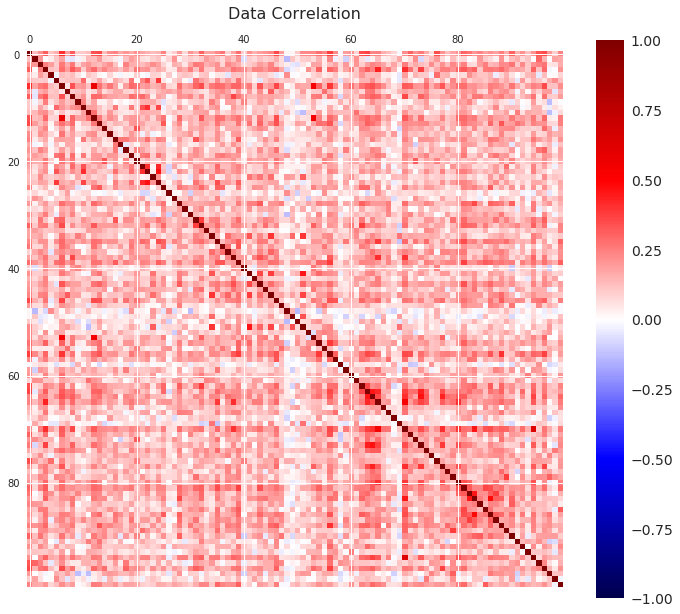

In [372]:
src.plot.corr_heatmap(df_volas.corr(), 'Data Correlation')

### VAR estimation

$r_{i,t} = \alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}  + u_{i,t}$

where
- $r_{i,t}$: $1 \times 1$ (asset excess returns)
- $\alpha_i$: $1 \times 1$ (intercepts/pricing errors)
- $f_{k,t}$: $1 \times 1$ (factor excess returns)
- $\beta_{i,k}$: $1 \times 1$ (factor loadings)
- $\gamma_{i,j}$: $1 \times 1$ (VAR coefficients)
- $u_{i,t}$: $1 \times 1$ (error term)

Adaptive Elastic Net with hyperparameters $\lambda, \kappa$

$(\hat{\alpha}, \hat{\beta}, \hat{\gamma})= \underset{(\alpha, \beta, \gamma)}{argmin} \Bigg[ \frac{1}{2NT}\sum_{i=1}^{N}\sum_{t=1}^{T} \Big(r_{i,t} - \big(\alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}\big)\Big)^2 + \lambda \sum_{i=1}^{N}\sum_{j=1}^{N} w_{i,j} \big(\kappa |\gamma_{i,j}| + (1-\kappa) \frac{1}{2} \gamma_{i,j}^2\big)\Bigg]$

weights are set to $w_{i,j} =|\hat{\beta}_{i,j,OLS}|^{-1}$

In [373]:
# Regular VAR
var = src.VAR(df_volas, p_lags=1)

In [374]:
# VAR including SPY as a series
var = src.VAR(df_volas.join(df_spy_vola), p_lags=1)

In [375]:
# VAR with exogenous factor regressor
var = src.VARX(df_volas, df_spy_vola, p_lags=1)

In [376]:
hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
                       'lambdau': np.geomspace(1e-10, 1e0, 15),
                       }

In [377]:
cv = var.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.1min finished


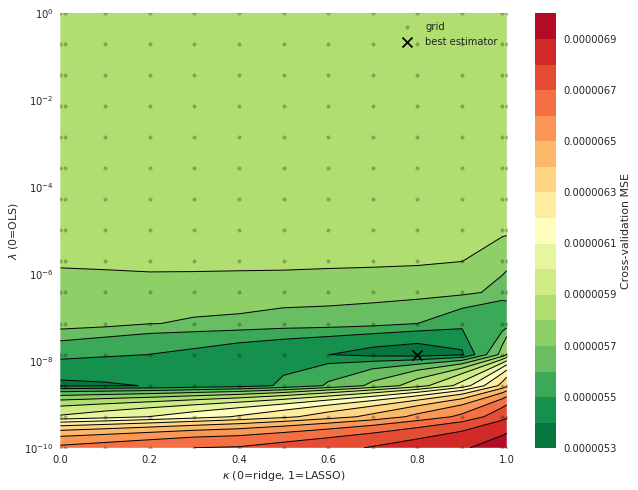

In [378]:
src.plot.cv_contour(cv, 15, logy=True)

In [379]:
gammas = var.var_1_matrix_
n_series = var.n_series
density = (gammas!=0).sum()/n_series**2*n_series
κ = cv.best_params_['alpha']
λ = cv.best_params_['lambdau']
print('VAR(1) matrix is {:.2f}% dense.'.format(density))
print('Best hyperparameters are alpha={:.2f}, lambda={:.10f}.'.format(κ, λ))
print('Average VAR spillover is {:.4f}, absolute {:.4f}'.format(gammas.mean(), abs(gammas).mean()))
try:
    print('Mean factor loading is {:.4f}, with min {:.4f}, max {:.4f}'.format(var.exog_loadings_.mean(), var.exog_loadings_.min(), var.exog_loadings_.max()))
except:
    pass

VAR(1) matrix is 49.54% dense.
Best hyperparameters are alpha=0.80, lambda=0.0000000139.
Average VAR spillover is -0.0008, absolute 0.0119
Mean factor loading is 0.5722, with min -0.0231, max 1.5281


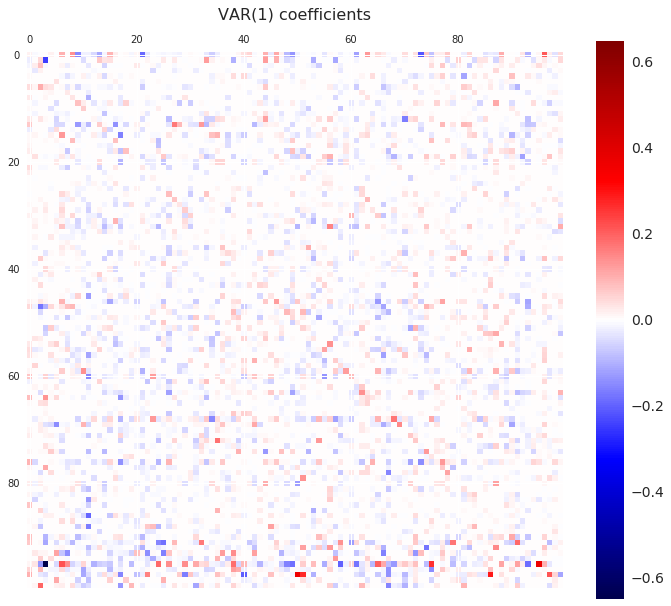

In [380]:
absmax = abs(gammas).max()
src.plot.corr_heatmap(gammas, 'VAR(1) coefficients', vmin=-absmax, vmax=absmax)

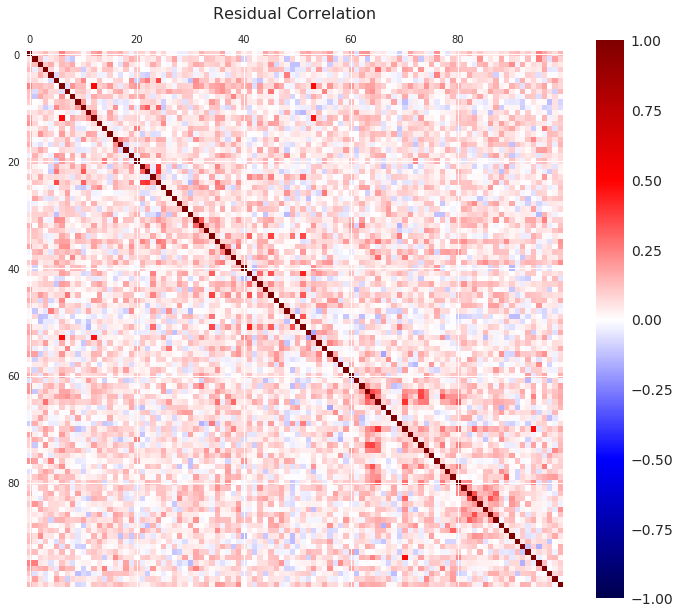

In [381]:
src.plot.corr_heatmap(pd.DataFrame(var.residuals_).corr(), 'Residual Correlation')

In [382]:
#src.plot.corr_heatmap(pd.DataFrame(var.exog_residuals_).corr(), 'Factor Model Residual Correlation')

### Covariance matrix estimation

### FEVD

In [383]:
horizon = 10
fevd = src.FEVD(var.var_1_matrix_, var.residual_cov_('LW'))

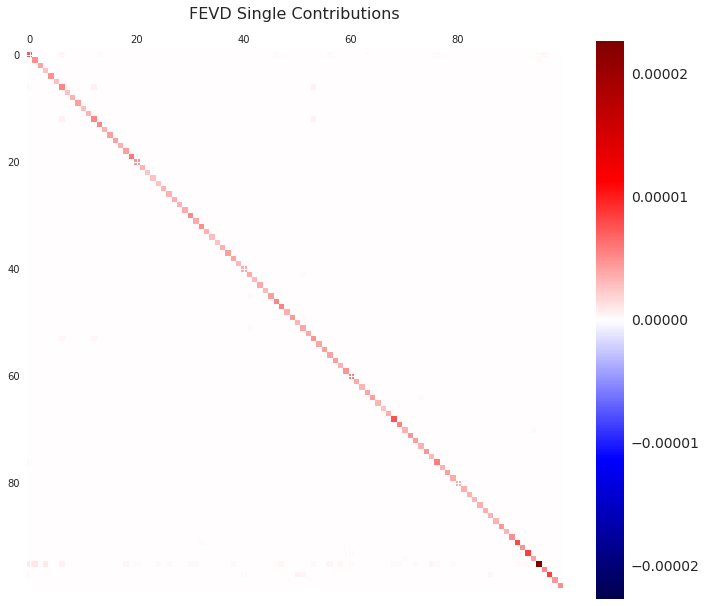

In [384]:
absmax = abs(fevd.fev_single(horizon)).max()
src.plot.corr_heatmap(pd.DataFrame(fevd.fev_single(horizon)), 'FEVD Single Contributions', vmin=-absmax, vmax=absmax)

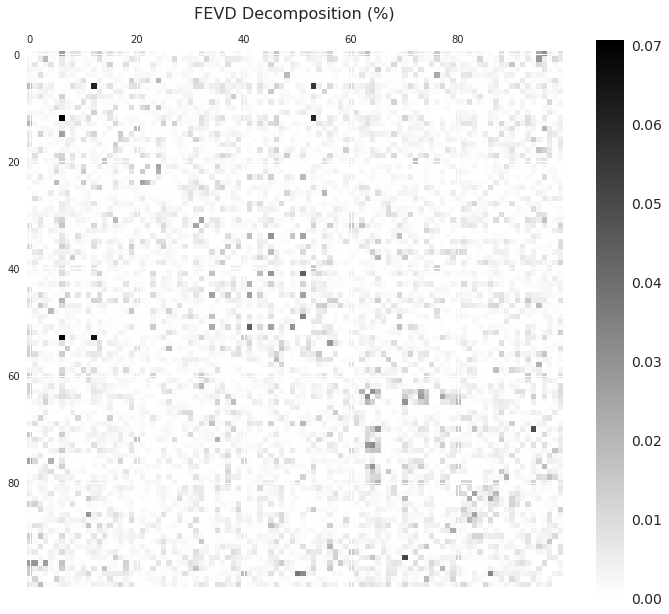

In [385]:
src.plot.corr_heatmap(pd.DataFrame(fevd.decompose_pct(horizon=horizon))-np.diag(np.diag(fevd.decompose_pct(horizon=horizon))), 'FEVD Decomposition (%)', vmin=0, vmax=None, cmap='binary')

### Network structure

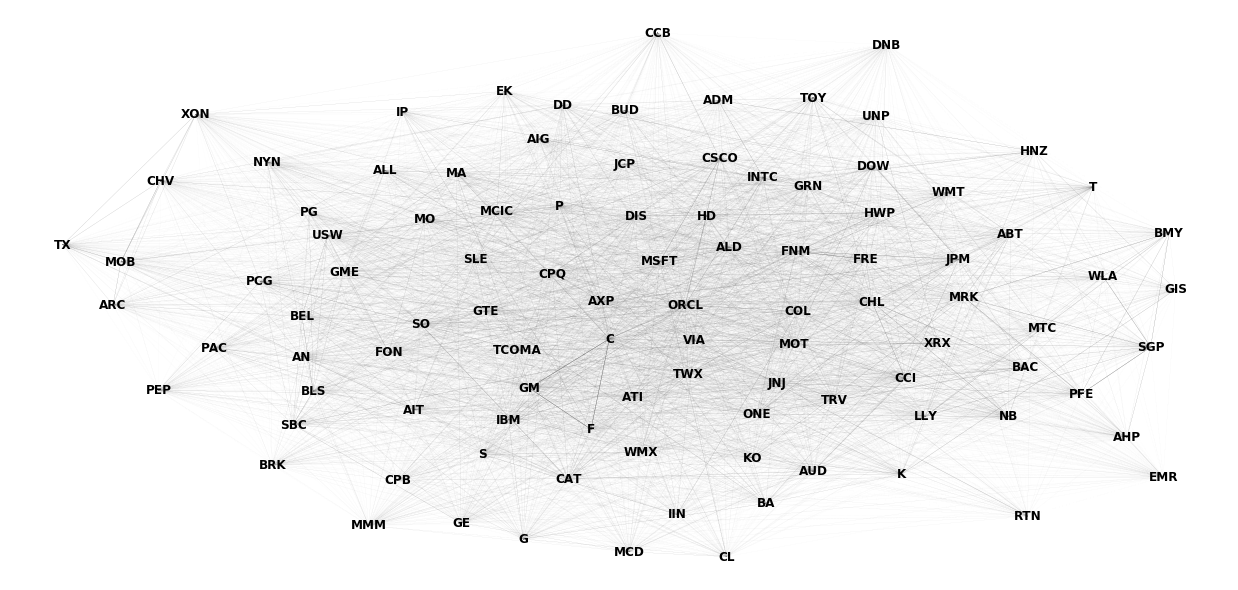

In [386]:
graph = fevd.to_graph(1)
column_to_ticker = dict(pd.read_csv('../data/processed/annual/{}/tickers.csv'.format(year))['permno_to_ticker'])
src.plot.network_graph(graph, column_to_ticker)
#nx.eigenvector_centrality(graph, weight='weight')

In [396]:
src.utils.lookup_ticker('GIS', year)

permno                    17144
comnam        GENERAL MILLS INC
namedt      1968-01-02 00:00:00
nameendt    2002-01-01 00:00:00
exchcd                        1
Name: GIS, dtype: object

## Load data

In [5]:
df_desc = src.loader.load_descriptive()

In [32]:
# inputs
year = 2017
selected_factors = ['mktrf']

In [33]:
# load year data & select factors
df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all_vola(year)
fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)

In [34]:
fac_est = src.loader.load_spy(year=year, columns=['vola'])
fac_ana = src.loader.load_spy(year=year+1, columns=['vola'])

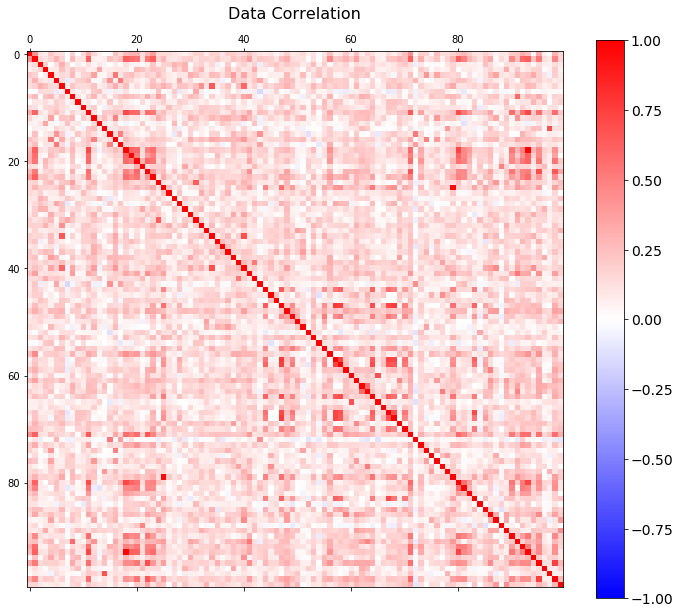

In [35]:
src.plot.corr_heatmap(df_est.corr(), 'Data Correlation')

## Estimate

### Stage 1:  FAVAR
$r_{i,t} = \alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}  + u_{i,t}$

where
- $r_{i,t}$: $1 \times 1$ (asset excess returns)
- $\alpha_i$: $1 \times 1$ (intercepts/pricing errors)
- $f_{k,t}$: $1 \times 1$ (factor excess returns)
- $\beta_{i,k}$: $1 \times 1$ (factor loadings)
- $\gamma_{i,j}$: $1 \times 1$ (VAR coefficients)
- $u_{i,t}$: $1 \times 1$ (error term)

Adaptive Elastic Net with hyperparameters $\lambda, \kappa$

$(\hat{\alpha}, \hat{\beta}, \hat{\gamma})= \underset{(\alpha, \beta, \gamma)}{argmin} \Bigg[ \frac{1}{2NT}\sum_{i=1}^{N}\sum_{t=1}^{T} \Big(r_{i,t} - \big(\alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}\big)\Big)^2 + \lambda \sum_{i=1}^{N}\sum_{j=1}^{N} w_{i,j} \big(\kappa |\gamma_{i,j}| + (1-\kappa) \frac{1}{2} \gamma_{i,j}^2\big)\Bigg]$

weights are set to $w_{i,j} =|\hat{\beta}_{i,j,OLS}|^{-1}$

In [288]:
from sklearn.decomposition import FactorAnalysis
factors = pd.DataFrame(FactorAnalysis(n_components=1).fit_transform(df_est))
favar = src.FAVAR(df_est, factors, p_lags=1)

In [289]:
favar = src.FAVAR(df_est, fac_est, p_lags=1)

In [290]:
hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
                       'lambdau': np.geomspace(1e-10, 1e-6, 12),
                       }

In [292]:
cv = favar.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)

Fitting 10 folds for each of 156 candidates, totalling 1560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1560 out of 1560 | elapsed:  5.3min finished


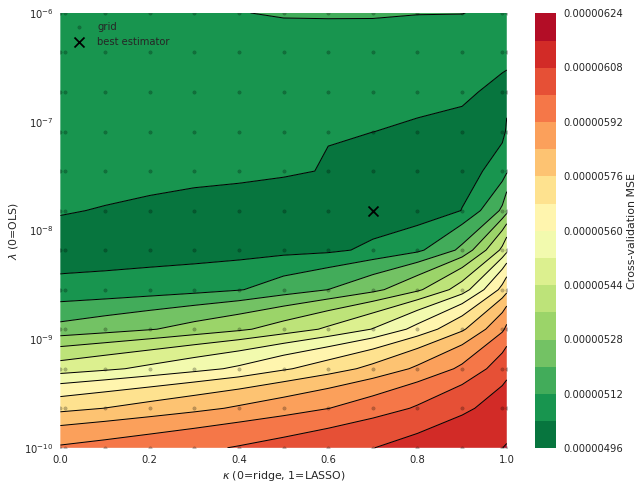

In [293]:
src.plot.cv_contour(cv, 15, logy=True)

In [294]:
gammas = favar.var_1_matrix_
n_series = favar.n_series
density = (gammas!=0).sum()/n_series**2*n_series
κ = cv.best_params_['alpha']
λ = cv.best_params_['lambdau']
print('VAR(1) matrix is {}% dense.'.format(density))
print('Best hyperparameters are alpha={:.2f}, lambda={:.10f}.'.format(κ, λ))
print('Average VAR spillover is {:.4f}, absolute {:.4f}'.format(gammas.mean(), abs(gammas).mean()))

VAR(1) matrix is 53.300000000000004% dense.
Best hyperparameters are alpha=0.70, lambda=0.0000000152.
Average VAR spillover is -0.0021, absolute 0.0093


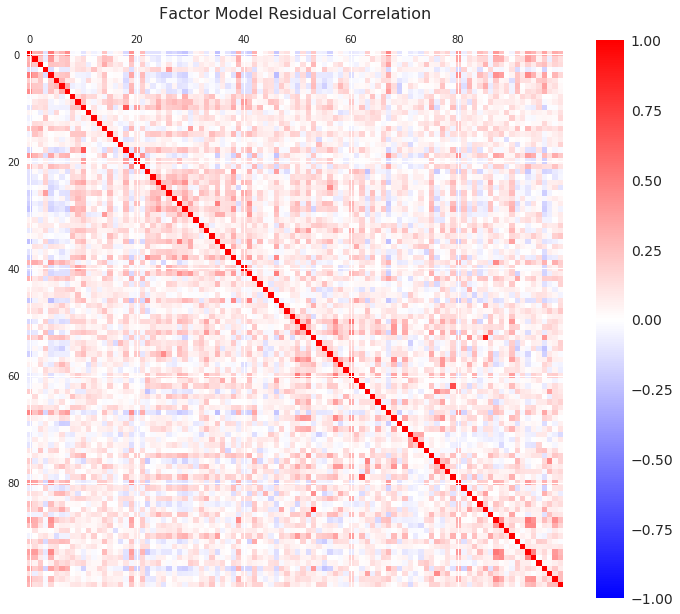

In [265]:
src.plot.corr_heatmap(pd.DataFrame(favar.factor_residuals_).corr(), 'Factor Model Residual Correlation')

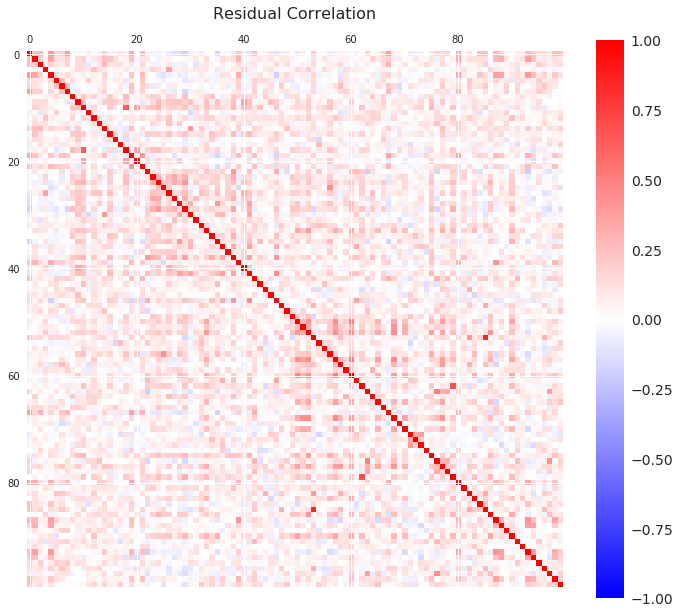

In [266]:
src.plot.corr_heatmap(pd.DataFrame(favar.residuals_).corr(), 'Residual Correlation')

### Stage 2: Covariances

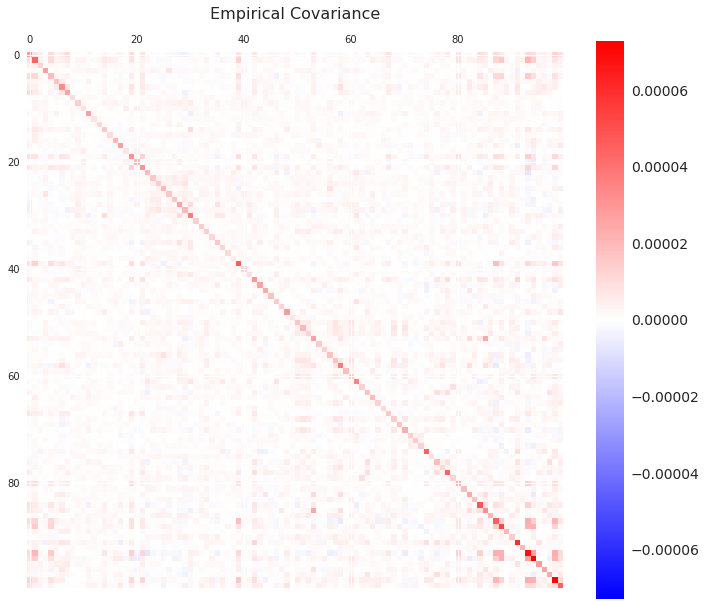

In [267]:
absmax = abs(favar.residual_cov_('sample')).max()
src.plot.corr_heatmap(pd.DataFrame(favar.residual_cov_('sample')), 'Empirical Covariance', vmin=-absmax, vmax=absmax)

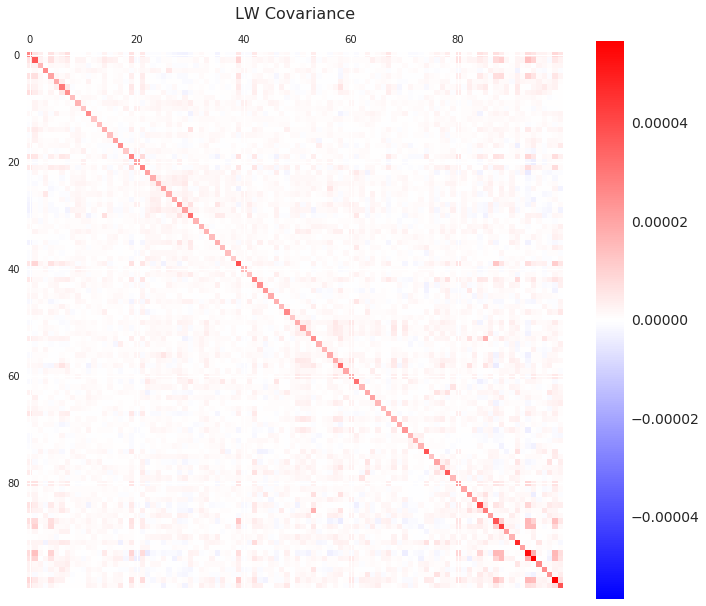

In [268]:
absmax = abs(favar.residual_cov_('LW')).max()
src.plot.corr_heatmap(pd.DataFrame(favar.residual_cov_('LW')), 'LW Covariance', vmin=-absmax, vmax=absmax)

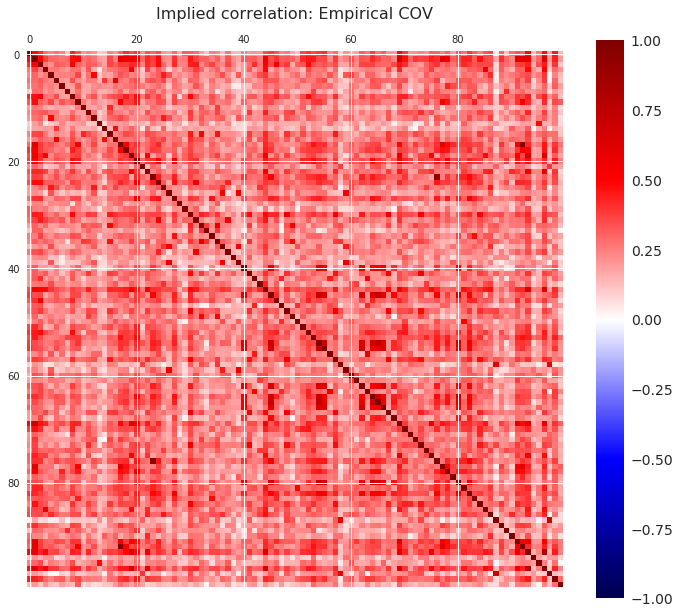

In [125]:
src.plot.corr_heatmap(src.utils.cov_to_corr(favar.residual_cov_('sample')), 'Implied correlation: Empirical COV')

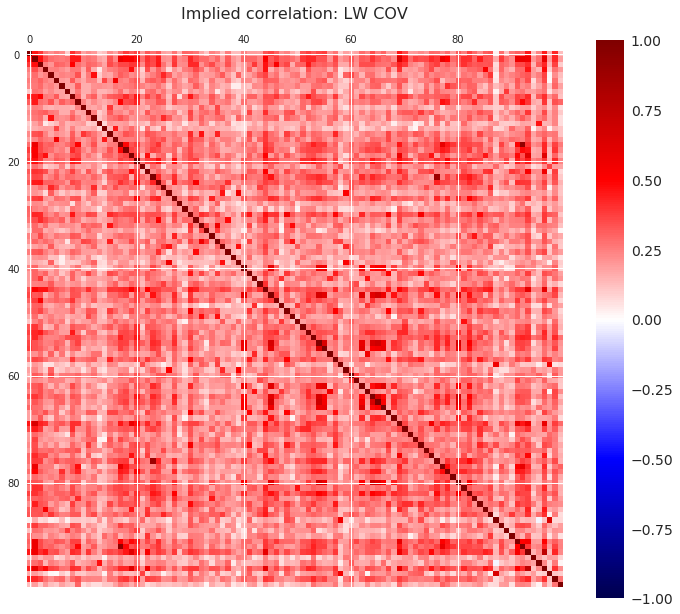

In [124]:
src.plot.corr_heatmap(src.utils.cov_to_corr(favar.residual_cov_('LW')), 'Implied correlation: LW COV')

## FEVD

In [96]:
fevd = src.FEVD(favar.var_1_matrix_, favar.residual_cov_('LW'))

In [97]:
horizon = 10

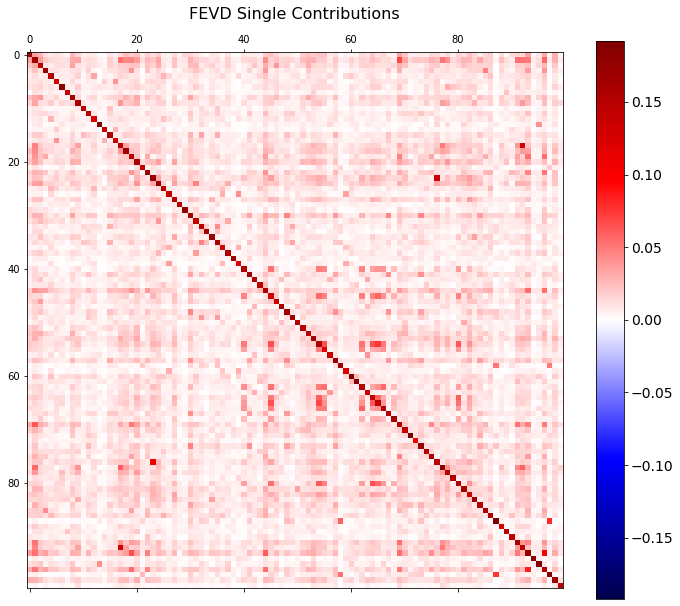

In [98]:
absmax = abs(fevd.fev_single(horizon)).max()
src.plot.corr_heatmap(pd.DataFrame(fevd.fev_single(horizon)), 'FEVD Single Contributions', vmin=-absmax, vmax=absmax)

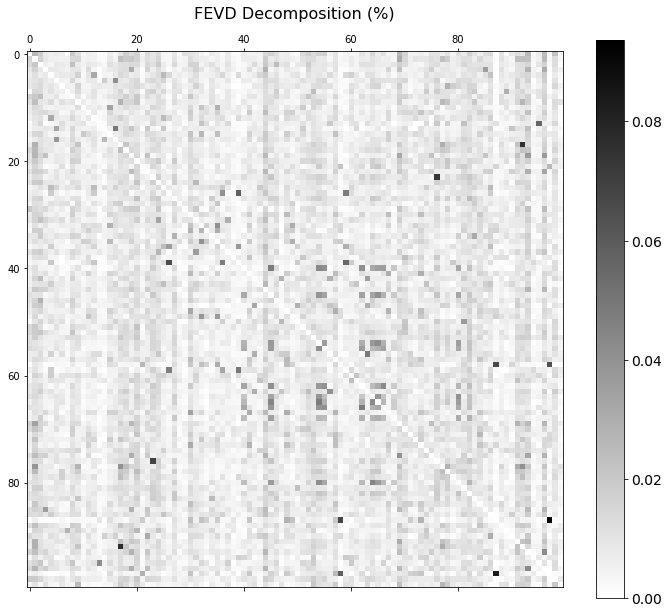

In [99]:
src.plot.corr_heatmap(pd.DataFrame(fevd.decompose_pct(horizon=horizon))-np.diag(np.diag(fevd.decompose_pct(horizon=horizon))), 'FEVD Decomposition (%)', vmin=0, vmax=None, cmap='binary')

In [28]:
fevd.in_connectedness(horizon=horizon).mean()

0.9512653968995914

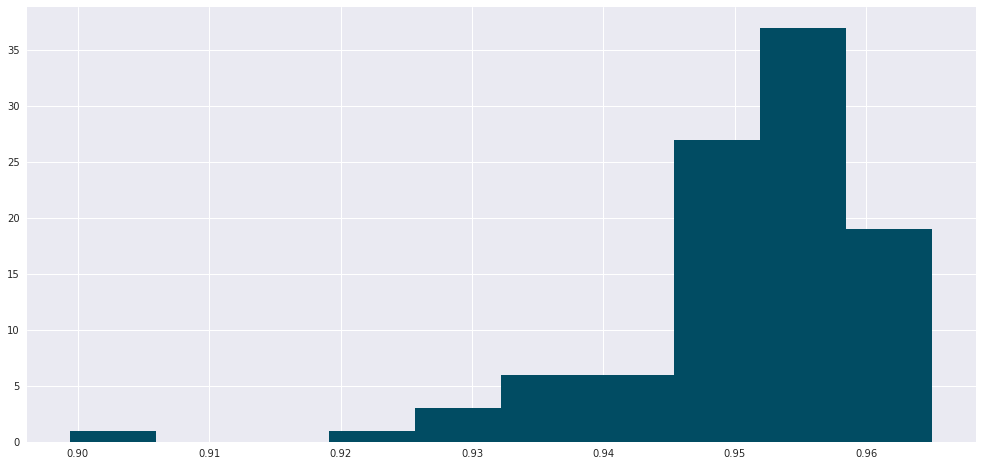

In [29]:
pd.Series(fevd.in_connectedness(horizon=horizon).ravel()).hist()
plt.show()

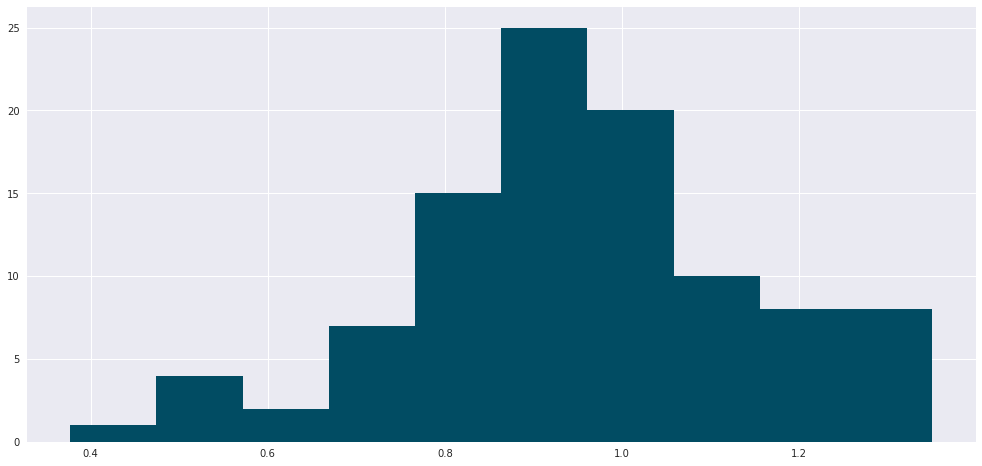

In [30]:
pd.Series(fevd.out_connectedness(horizon=horizon).ravel()).hist()
plt.show()

In [106]:
fevd.average_connectedness(horizon)

0.8601165934330517

In [107]:
fevd_10 = fevd.summarize(10)

In [108]:
graph = fevd.to_graph(1)
column_to_ticker = src.utils.map_column_to_ticker(df_est, df_desc.reset_index())
src.plot.network_graph(graph, column_to_ticker)
#nx.eigenvector_centrality(graph)

NameError: name 'df_desc' is not defined

In [282]:
df_desc.loc[[int(i) for i in df_est.columns.to_list()]].reset_index().groupby('permno').agg(lambda x: x.mode()).set_index('ticker')

,comnam,st_date,end_date
ticker,,,
JAVA,SUN MICROSYSTEMS INC,1986-03-31,2010-01-29
ORCL,ORACLE CORP,1986-03-31,2019-12-31
MSFT,MICROSOFT CORP,1986-03-31,2019-12-31
ALD,ALLIED CHEMICAL CORP,1925-12-31,2019-12-31
"[EMC, EMCS]",E M C CORP MA,1986-04-30,2016-09-30
...,...,...,...
"[Q, QWST]",QWEST COMMUNICATIONS INTL INC,1997-06-30,2011-03-31
LMG,A T & T CORP,1999-03-31,2001-08-31
GS,GOLDMAN SACHS GROUP INC,1999-05-28,2019-12-31


In [221]:
create_results_data(df_est, df_ana, favar, cv, fevd, horizon).corr().round(4)

,mean_est_ret,mean_ana_ret,beta,alpha,in_connectedness,out_connectedness,fev_others,fev_all,average_connectedness
mean_est_ret,1.0000,0.7661,0.7386,0.9828,0.5047,0.4252,0.7904,0.8787,-0.0
mean_ana_ret,0.7661,1.0000,0.3735,0.7396,0.2095,0.1602,0.4733,0.6671,0.0
beta,0.7386,0.3735,1.0000,0.7332,0.7618,0.6978,0.7671,0.5764,0.0
alpha,0.9828,0.7396,0.7332,1.0000,0.4952,0.4167,0.7896,0.8514,-0.0
in_connectedness,0.5047,0.2095,0.7618,0.4952,1.0000,0.9618,0.7304,0.3223,-0.0
out_connectedness,0.4252,0.1602,0.6978,0.4167,0.9618,1.0000,0.7281,0.2682,0.0
fev_others,0.7904,0.4733,0.7671,0.7896,0.7304,0.7281,1.0000,0.7775,0.0
fev_all,0.8787,0.6671,0.5764,0.8514,0.3223,0.2682,0.7775,1.0000,0.0
average_connectedness,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,1.0


## Analysis

In [71]:
def create_results_data(df_est, df_ana, favar, cv, fevd, horizon): #graph
    '''Creates a dataframe containing estimation results.'''
    df = pd.DataFrame(index=favar.var_data.columns)
    df['mean_est_ret'] = df_est.mean()*252
    df['mean_ana_ret'] = df_ana.mean()*252
    df['beta'] = favar.factor_loadings_
    df['alpha'] = favar.intercepts_
    df['in_connectedness'] = fevd.in_connectedness(horizon=horizon)
    df['out_connectedness'] = fevd.out_connectedness(horizon=horizon)
    df['fev_others'] = fevd.fev_others(horizon=horizon)
    df['fev_all'] = fevd.fev_all(horizon=horizon)
    df['average_connectedness'] = fevd.average_connectedness(horizon=horizon) 
    #df['eigenvector_centrality'] = np.linalg.eig(favar.residual_cov_('LW'))[1][:,0]
    #df['network_centraility'] = nx.eigenvector_centrality(graph)
    
    return df

In [581]:
def estimate_single_year(year, selected_factors, grid, horizon):
    
    # load data
    df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all(year)
    fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)
    
    # favar
    favar = src.FAVAR(df_est, fac_est, p_lags=1)
    cv = favar.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)
    
    # fevd
    fevd = src.FEVD(favar.var_1_matrix_, favar.residual_cov_('LW'))
    
    # save results
    df_year = create_results_data(df_est, df_ana, favar, cv, fevd, horizon)
    
    return df_year
    

In [580]:
def estimate_single_year_vola(year, selected_factors, grid, horizon):
    
    # load data
    df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all_vola(year)
    fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)
    
    # favar
    favar = src.FAVAR(df_est, fac_est, p_lags=1)
    cv = favar.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)
    
    # fevd
    fevd = src.FEVD(favar.var_1_matrix_, favar.residual_cov_('LW'))
    
    # save results
    df_year = create_results_data(df_est, df_ana, favar, cv, fevd, horizon)
    
    return df_year
    

In [74]:
estimate_single_year(2001, ['mktrf'], hyperparameter_grid, 10)df_results

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.3min finished


,mean_est_ret,mean_ana_ret,beta,alpha,in_connectedness,out_connectedness,fev_others,fev_all,average_connectedness
10078,-0.435139,-1.048483,2.613796,-0.000791,0.792499,1.344933,0.004125,0.001273,0.596741
10104,-0.435277,-0.035479,2.375174,-0.000822,0.665288,0.684005,0.001876,0.001043,0.596741
10107,0.527127,-0.158045,1.382360,0.002203,0.570277,0.444972,0.000416,0.000336,0.596741
10145,-0.195847,-0.193006,1.487741,0.000291,0.481237,0.379087,0.000380,0.000432,0.596741
10147,-1.143841,-0.423182,2.919300,-0.003235,0.736221,0.865730,0.003083,0.001307,0.596741
...,...,...,...,...,...,...,...,...,...
85032,-0.876547,0.095444,1.082932,-0.002839,0.499858,0.336465,0.000819,0.000942,0.596741
86868,-0.036642,-0.233482,1.554035,0.000829,0.666004,0.752188,0.000605,0.000315,0.596741
87031,-0.239823,-0.365024,1.321314,0.000447,0.511296,0.383917,0.000792,0.000848,0.596741
87842,-0.042514,-0.085259,0.679305,0.000253,0.593467,0.475000,0.000379,0.000275,0.596741


In [92]:
df_results = pd.DataFrame([])
for year in range(2000, 2019):
    df_year = estimate_single_year(year=year, selected_factors=['mktrf'], grid=hyperparameter_grid, horizon=10)
    df_year.index = pd.MultiIndex.from_product([[year], df_year.index])
    
    df_results = df_results.append(df_year)
    df_results.to_csv('../data/interim/df_results.csv')
    print('finished year {}'.format(year))
    

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.5min finished


finished year 2000
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.5min finished


finished year 2001
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.2min finished


finished year 2002
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.6min finished


finished year 2003
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.3min finished


finished year 2004
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2005
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.8min finished


finished year 2006
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.5min finished


finished year 2007
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.1min finished


finished year 2008
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.8min finished


finished year 2009
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  8.1min finished


finished year 2010
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.2min finished


finished year 2011
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2012
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.0min finished


finished year 2013
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.2min finished


finished year 2014
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.3min finished


finished year 2015
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.1min finished


finished year 2016
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2017
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.8min finished


finished year 2018


In [141]:
df_results.corr().round(4)

,mean_est_ret,mean_ana_ret,beta,alpha,in_connectedness,out_connectedness,fev_others,fev_all,average_connectedness
mean_est_ret,1.0000,-0.0527,0.0914,0.7063,-0.0934,-0.0257,-0.0408,-0.0773,-0.2348
mean_ana_ret,-0.0527,1.0000,-0.0083,-0.0107,0.0150,0.0074,0.0136,0.0240,0.0452
beta,0.0914,-0.0083,1.0000,-0.0037,0.1715,0.2131,0.3401,0.3615,-0.0540
alpha,0.7063,-0.0107,-0.0037,1.0000,0.1259,0.0977,0.1984,0.1873,0.1384
in_connectedness,-0.0934,0.0150,0.1715,0.1259,1.0000,0.9215,0.5622,0.3883,0.6319
out_connectedness,-0.0257,0.0074,0.2131,0.0977,0.9215,1.0000,0.5609,0.2851,0.3932
fev_others,-0.0408,0.0136,0.3401,0.1984,0.5622,0.5609,1.0000,0.8401,0.4416
fev_all,-0.0773,0.0240,0.3615,0.1873,0.3883,0.2851,0.8401,1.0000,0.4611
average_connectedness,-0.2348,0.0452,-0.0540,0.1384,0.6319,0.3932,0.4416,0.4611,1.0000


In [148]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('mean_est_ret', ['beta', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_est_ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     13.54
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           9.62e-09
Time:                        13:22:12   Log-Likelihood:                -234.52
No. Observations:                1900   AIC:                             477.0
Df Residuals:                    1896   BIC:                             499.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1507      0.027      5.631      0.000       0.098       0.203
beta                 0.0783      0.016      4.831      0.000       0.047       0.110
in_connectedness    -0.1803      0.050     -3.627      0.000      -0.278      -0.083
fev_others         -11.7620     13.845     -0.850      0.396     -38.915      15.391
==============================================================================
Omnibus:                      155.409   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              887.275
Skew:                           0.070   Prob(JB):                    2.14e-193
Kurtosis:                       6.345   Cond. No.                     3.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('mean_ana_ret', ['beta', 'alpha', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_ana_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3150
Date:                Mon, 28 Sep 2020   Prob (F-statistic):              0.868
Time:                        23:41:02   Log-Likelihood:                -1685.1
No. Observations:                1896   AIC:                             3380.
Df Residuals:                    1891   BIC:                             3408.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1008      0.058      1.740      0.082      -0.013       0.214
beta                -0.0221      0.035     -0.631      0.528      -0.091       0.047
alpha               -9.4724     14.639     -0.647      0.518     -38.182      19.237
in_connectedness     0.0411      0.107      0.384      0.701      -0.169       0.251
fev_others          16.4674     30.917      0.533      0.594     -44.168      77.103
==============================================================================
Omnibus:                     4666.037   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         70336179.752
Skew:                          25.009   Prob(JB):                         0.00
Kurtosis:                     945.247   Cond. No.                     3.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('beta', ['alpha', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beta   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     87.36
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.04e-53
Time:                        23:42:30   Log-Likelihood:                -890.04
No. Observations:                1900   AIC:                             1788.
Df Residuals:                    1896   BIC:                             1810.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9400      0.031     30.108      0.000       0.879       1.001
alpha              -32.0714      9.568     -3.352      0.001     -50.837     -13.306
in_connectedness    -0.0735      0.070     -1.047      0.295      -0.211       0.064
fev_others         265.1943     18.884     14.043      0.000     228.158     302.231
==============================================================================
Omnibus:                       14.657   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.546
Skew:                          -0.017   Prob(JB):                     2.10e-05
Kurtosis:                       3.521   Cond. No.                     2.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [257]:
from sklearn.model_selection import PredefinedSplit

In [258]:
var = VAR(df_volas, 1)

In [259]:
varx = VARX(df_volas, df_spy_vola, 1)

In [260]:
varx.fit_elastic_net(0.5, 1e-4)